In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
%matplotlib inline
from geopy.geocoders import Nominatim
from scipy.spatial.distance import pdist
import seaborn as sns
print('Libraries imported.')

Libraries imported.


In [3]:
CLIENT_ID = 'DS3TISPLJMMRCPFQ1ZXU2XSLNEJWLUSBVQCT24JMM0POEXIM' # your Foursquare ID
CLIENT_SECRET = 'TFVW1F5H2IIGPE2IKNHEZRGBTEJB2Q5V4FAX0PR353ULY3FO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DS3TISPLJMMRCPFQ1ZXU2XSLNEJWLUSBVQCT24JMM0POEXIM
CLIENT_SECRET:TFVW1F5H2IIGPE2IKNHEZRGBTEJB2Q5V4FAX0PR353ULY3FO


In [4]:
LIMIT = 100 
cities = ['Cracow', 'Poznan', 'Warsaw', 'Wroclaw']
results = {}
for city in cities:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        city,
        LIMIT,
        "4bf58dd8d48988d1e7931735,4bf58dd8d48988d1e9931735,4bf58dd8d48988d1fe941735") # PIZZA PLACE CATEGORY ID
    results[city] = requests.get(url).json()


In [30]:
df_venues={}
for city in cities:
    venues = json_normalize(results[city]['response']['groups'][0]['items'])
    df_venues[city] = venues[['venue.name', 'venue.location.address','categories','venue.id', 'venue.location.lat', 'venue.location.lng']]
    df_venues[city].columns = ['Name', 'Address','Category','VenueID', 'Lat', 'Lng']

KeyError: "['categories'] not in index"

In [38]:
venues = json_normalize(results[city]['response']['groups'][0]['items'])
venues['venue.categories'][0]

[{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_jazzclub_',
   'suffix': '.png'},
  'id': '4bf58dd8d48988d1e7931735',
  'name': 'Jazz Club',
  'pluralName': 'Jazz Clubs',
  'primary': True,
  'shortName': 'Jazz Club'}]

In [12]:
geolocator = Nominatim(user_agent="capstone")
maps= {}
for city in cities:
    location = geolocator.geocode(city + ', Poland')
    city_lat = location.latitude
    city_lng = location.longitude
    maps[city] = folium.Map(location=[city_lat, city_lng], zoom_start=12)

    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])  
    print(f"Total number of music clubs and stores in {city} = ", results[city]['response']['totalResults'])
    print("Showing Top 100")

Total number of music clubs and stores in Cracow =  15
Showing Top 100
Total number of music clubs and stores in Poznan =  5
Showing Top 100
Total number of music clubs and stores in Warsaw =  26
Showing Top 100
Total number of music clubs and stores in Wroclaw =  8
Showing Top 100


Cracow

In [13]:
maps[cities[0]]

Poznan

In [14]:
maps[cities[1]]


Warsaw

In [15]:
maps[cities[2]]

Wroclaw

In [16]:
maps[cities[3]]

In [17]:
df_cracow = df_venues.get('Cracow')

In [18]:
df_wroclaw = df_venues.get('Wroclaw')

In [19]:
df_warsaw = df_venues.get('Warsaw')

In [20]:
df_poznan = df_venues.get('Poznan')

<h1>Data analysis </h1>

<h3>Cracow</h3>

In [21]:
from sklearn.cluster import KMeans

In [22]:
df_cluster = df_cracow.drop(['Name','Address', 'VenueID'], 1)

In [23]:
kclusters = 4

In [24]:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)

In [25]:
kmeans.labels_[0:13]

array([1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 0])

In [26]:
df_cracow.insert(0, 'Cluster Labels', kmeans.labels_)
df_cracow.head(2)

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,1,Harris Piano Jazz,Rynek Główny 28,4bbf90a2b492d13a4fdfa260,50.061703,19.935660
1,1,Jazz Rock Cafe,Sławkowska 12,4befe97724f19c747926f983,50.063866,19.937492


In [27]:
# create map
latitude=50.049683
longitude=19.944544
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_cracow['Lat'], df_cracow['Lng'],  df_cracow['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
df_cracow['Cluster Labels'].value_counts()

1    10
3     3
2     1
0     1
Name: Cluster Labels, dtype: int64

We will consider cluster 1

In [31]:
df_cracow_fin = df_cracow.loc[df_cracow['Cluster Labels'] == 1]

In [32]:
df_cracow_fin

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,1,Harris Piano Jazz,Rynek Główny 28,4bbf90a2b492d13a4fdfa260,50.061703,19.935660
1,1,Jazz Rock Cafe,Sławkowska 12,4befe97724f19c747926f983,50.063866,19.937492
2,1,Hard Rock Cafe Kraków,Main Market / Mariacki Square 9,4c28c33b9eb195213e982959,50.061442,19.938733
3,1,The Piano Rouge,Rynek Główny 46,4c7e5d5e3b22a1cdc388619e,50.062130,19.938760
4,1,Księgarnia Muzyczna Kurant,Rynek Główny 36,51bbae5d498e408f1a985606,50.062341,19.936778
5,1,Jazz Club U Muniaka,Floriańska 3,4f0231f9be7bbcd4f5cd8fd0,50.062189,19.939250
7,1,Piec Art Acoustic Jazz Club,NaN,4dfa5cced164bbe54616bab9,50.062661,19.934744
8,1,Chicago Jazz Live Music,NaN,52f6a5a5498e48263b2adaca,50.063970,19.937753
10,1,Klub Muzyczny Awaria,Mikołajska 9,4bfcd3a7e930952171f061ab,50.061266,19.942233
11,1,Carpe Diem 2,ul. Sławkowska 6,4be96c6ca117b713e28281c8,50.063289,19.937282


In [33]:
# create map
latitude=df_cracow_fin['Lat'].mean()
longitude=df_cracow_fin['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=16)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(df_cracow_fin['Lat'], df_cracow_fin['Lng']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=label,
        #color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Mean distance between venues in cluster:

In [34]:
distance_cracow = pdist(df_cluster, 'cityblock')
print('The mean Manhattan distance between points equals ' + str(distance_cracow.mean()))

The mean Manhattan distance between points equals 0.024830518334050092


In [35]:
ratings={}
i=0
for id in df_cracow_fin['VenueID']:
    URL = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        ) 
    results = grab = requests.get(URL).json()
    rate = results['response']['venue']['rating']
    ratings[id]=rate
    i=i+1
    print(results['response']['venue']['rating'])
    
df_cracow_fin['Rating']=df_cracow_fin['VenueID'].map(ratings)
df_cracow_fin

7.9
7.9
8.1
7.4
6.8
6.5
6.3
6.3
5.9
5.8


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Cluster Labels,Name,Address,VenueID,Lat,Lng,Rating
0,1,Harris Piano Jazz,Rynek Główny 28,4bbf90a2b492d13a4fdfa260,50.061703,19.935660,7.9
1,1,Jazz Rock Cafe,Sławkowska 12,4befe97724f19c747926f983,50.063866,19.937492,7.9
2,1,Hard Rock Cafe Kraków,Main Market / Mariacki Square 9,4c28c33b9eb195213e982959,50.061442,19.938733,8.1
3,1,The Piano Rouge,Rynek Główny 46,4c7e5d5e3b22a1cdc388619e,50.062130,19.938760,7.4
4,1,Księgarnia Muzyczna Kurant,Rynek Główny 36,51bbae5d498e408f1a985606,50.062341,19.936778,6.8
5,1,Jazz Club U Muniaka,Floriańska 3,4f0231f9be7bbcd4f5cd8fd0,50.062189,19.939250,6.5
7,1,Piec Art Acoustic Jazz Club,NaN,4dfa5cced164bbe54616bab9,50.062661,19.934744,6.3
8,1,Chicago Jazz Live Music,NaN,52f6a5a5498e48263b2adaca,50.063970,19.937753,6.3
10,1,Klub Muzyczny Awaria,Mikołajska 9,4bfcd3a7e930952171f061ab,50.061266,19.942233,5.9
11,1,Carpe Diem 2,ul. Sławkowska 6,4be96c6ca117b713e28281c8,50.063289,19.937282,5.8


In [36]:
df_cracow_fin

,Cluster Labels,Name,Address,VenueID,Lat,Lng,Rating
0,1,Harris Piano Jazz,Rynek Główny 28,4bbf90a2b492d13a4fdfa260,50.061703,19.935660,7.9
1,1,Jazz Rock Cafe,Sławkowska 12,4befe97724f19c747926f983,50.063866,19.937492,7.9
2,1,Hard Rock Cafe Kraków,Main Market / Mariacki Square 9,4c28c33b9eb195213e982959,50.061442,19.938733,8.1
3,1,The Piano Rouge,Rynek Główny 46,4c7e5d5e3b22a1cdc388619e,50.062130,19.938760,7.4
4,1,Księgarnia Muzyczna Kurant,Rynek Główny 36,51bbae5d498e408f1a985606,50.062341,19.936778,6.8
5,1,Jazz Club U Muniaka,Floriańska 3,4f0231f9be7bbcd4f5cd8fd0,50.062189,19.939250,6.5
7,1,Piec Art Acoustic Jazz Club,NaN,4dfa5cced164bbe54616bab9,50.062661,19.934744,6.3
8,1,Chicago Jazz Live Music,NaN,52f6a5a5498e48263b2adaca,50.063970,19.937753,6.3
10,1,Klub Muzyczny Awaria,Mikołajska 9,4bfcd3a7e930952171f061ab,50.061266,19.942233,5.9
11,1,Carpe Diem 2,ul. Sławkowska 6,4be96c6ca117b713e28281c8,50.063289,19.937282,5.8


<h3>Poznan </h3>

In [37]:
df_cluster = df_poznan.drop(['Name','Address', 'VenueID'], 1)
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)
kmeans.labels_[0:13]

array([3, 1, 2, 1, 0])

In [38]:
df_poznan.insert(0, 'Cluster Labels', kmeans.labels_)
df_poznan.head(2)

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,3,Blue Note,Kościuszki 79,4c93f79872dd224b349c9591,52.408352,16.919411
1,1,U Bazyla,Norwida 18a,4e18aa3c2271b0e971fea995,52.415897,16.913159


In [39]:
# create map
latitude=df_poznan['Lat'].mean()
longitude=df_poznan['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_poznan['Lat'], df_poznan['Lng'],  df_poznan['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [40]:
df_poznan['Cluster Labels'].value_counts()

1    2
3    1
2    1
0    1
Name: Cluster Labels, dtype: int64

We will consider Cluster 1

In [41]:
df_poznan_fin = df_poznan.loc[df_poznan['Cluster Labels'] == 1]

In [42]:
df_poznan_fin

,Cluster Labels,Name,Address,VenueID,Lat,Lng
1,1,U Bazyla,Norwida 18a,4e18aa3c2271b0e971fea995,52.415897,16.913159
3,1,U Bazyla,NaN,57ffbc5938faf6f1b8bd00c9,52.416519,16.911341


In [43]:
# create map
latitude=df_poznan_fin['Lat'].mean()
longitude=df_poznan_fin['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=16)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(df_poznan_fin['Lat'], df_poznan_fin['Lng']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=label,
        #color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
distance_poznan = pdist(df_cluster, 'cityblock')

In [45]:
print('The mean Manhattan distance between points equals ' + str(distance_poznan.mean()))

The mean Manhattan distance between points equals 0.02106487912992989


In [46]:
ratings={}
i=0
for id in df_poznan_fin['VenueID']:
    URL = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        ) 
    results = grab = requests.get(URL).json()
    rate = results['response']['venue']['rating']
    ratings[id]=rate
    i=i+1
    print(results['response']['venue']['rating'])
    
df_poznan_fin['Rating']=df_poznan_fin['VenueID'].map(ratings)
df_poznan_fin

6.8


KeyError: 'rating'

In [47]:
df_poznan_fin['Rating']=df_poznan_fin['VenueID'].map(ratings)
df_poznan_fin

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Cluster Labels,Name,Address,VenueID,Lat,Lng,Rating
1,1,U Bazyla,Norwida 18a,4e18aa3c2271b0e971fea995,52.415897,16.913159,6.8
3,1,U Bazyla,NaN,57ffbc5938faf6f1b8bd00c9,52.416519,16.911341,NaN


<h2>Warsaw</h2>

In [48]:
df_cluster = df_warsaw.drop(['Name','Address', 'VenueID'], 1)
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)
kmeans.labels_[0:13]

array([3, 3, 3, 0, 2, 3, 3, 2, 0, 1, 3, 0, 2])

In [49]:
df_warsaw.insert(0, 'Cluster Labels', kmeans.labels_)
df_warsaw.head(2)

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,3,miejsce Chwila,Żurawia 47,4ca4d4a75720b1f7db6d3def,52.227504,21.011277
1,3,Hard Rock Cafe Warsaw,"Ul. Zlota 59, Złote Tarasy, Mazovia Province",4b8d7690f964a5202ffd32e3,52.230041,21.003797


In [54]:
# create map
latitude=df_warsaw['Lat'].mean()
longitude=df_warsaw['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_warsaw['Lat'], df_warsaw['Lng'],  df_warsaw['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
df_warsaw['Cluster Labels'].value_counts()

3    15
0     6
2     4
1     1
Name: Cluster Labels, dtype: int64

Cluster 3 will be considered, since while cluster 0 has more venues, it's also more spread out.

In [55]:
df_warsaw_fin = df_warsaw.loc[df_warsaw['Cluster Labels'] == 3]
df_warsaw_fin

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,3,miejsce Chwila,Żurawia 47,4ca4d4a75720b1f7db6d3def,52.227504,21.011277
1,3,Hard Rock Cafe Warsaw,"Ul. Zlota 59, Złote Tarasy, Mazovia Province",4b8d7690f964a5202ffd32e3,52.230041,21.003797
2,3,12on14 Jazz Club,Noakowskiego 16,552e56de498ea54019222068,52.221727,21.010365
5,3,Side One,Chmielna 21,4e00fe1bb61c1fbe8dfc32ad,52.232110,21.014636
6,3,Spotkanie,Zygmunta Krasińskiego 2A,4c56b74e744a0f47f038c7cb,52.270811,20.992151
10,3,Klub Harenda,Krakowskie Przedmieście 4/6,4bd8408d35aad13a7f6390f3,52.238910,21.019010
16,3,Rock On,NaN,53347b9c498e1087fbda511c,52.238282,21.012887
17,3,Jazzarium Cafe,Wilcza 50/52,4eac58829adfbd5e5debe7dd,52.224138,21.012222
18,3,Lfx2,al.Jana Pawla II 43a lok 18a,4c99c0e3a004a1cd6944426e,52.242933,20.992144
19,3,Akwarium Jazz Club,NaN,5980d561237dee2ae99c3009,52.244324,21.014235


In [56]:
# create map
latitude=df_warsaw_fin['Lat'].mean()
longitude=df_warsaw_fin['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(df_warsaw_fin['Lat'], df_warsaw_fin['Lng']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=label,
        #color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [57]:
distance_warsaw = pdist(df_cluster, 'cityblock')
print('The mean Manhattan distance between points equals ' + str(distance_warsaw.mean()))

The mean Manhattan distance between points equals 0.05948023894761677


In [60]:
ratings={}
i=0
for id in df_warsaw_fin['VenueID']:
    URL = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        ) 
    results = grab = requests.get(URL).json()
    rate = results['response']['venue']['rating']
    ratings[id]=rate
    i=i+1
    print(results['response']['venue']['rating'])
    

7.9
8.0
7.7
7.2
7.2
5.8


KeyError: 'rating'

In [59]:
df_warsaw_fin['Rating']=df_warsaw_fin['VenueID'].map(ratings)
df_warsaw_fin

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Cluster Labels,Name,Address,VenueID,Lat,Lng,Rating
0,3,miejsce Chwila,Żurawia 47,4ca4d4a75720b1f7db6d3def,52.227504,21.011277,7.9
1,3,Hard Rock Cafe Warsaw,"Ul. Zlota 59, Złote Tarasy, Mazovia Province",4b8d7690f964a5202ffd32e3,52.230041,21.003797,8.0
2,3,12on14 Jazz Club,Noakowskiego 16,552e56de498ea54019222068,52.221727,21.010365,7.7
5,3,Side One,Chmielna 21,4e00fe1bb61c1fbe8dfc32ad,52.232110,21.014636,7.2
6,3,Spotkanie,Zygmunta Krasińskiego 2A,4c56b74e744a0f47f038c7cb,52.270811,20.992151,7.2
10,3,Klub Harenda,Krakowskie Przedmieście 4/6,4bd8408d35aad13a7f6390f3,52.238910,21.019010,5.8
16,3,Rock On,NaN,53347b9c498e1087fbda511c,52.238282,21.012887,NaN
17,3,Jazzarium Cafe,Wilcza 50/52,4eac58829adfbd5e5debe7dd,52.224138,21.012222,NaN
18,3,Lfx2,al.Jana Pawla II 43a lok 18a,4c99c0e3a004a1cd6944426e,52.242933,20.992144,NaN
19,3,Akwarium Jazz Club,NaN,5980d561237dee2ae99c3009,52.244324,21.014235,NaN


<h2>Wroclaw</h2>

In [61]:
df_cluster = df_wroclaw.drop(['Name','Address', 'VenueID'], 1)
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)
kmeans.labels_[0:13]

array([0, 0, 0, 1, 0, 0, 0, 0])

In [62]:
df_wroclaw.insert(0, 'Cluster Labels', kmeans.labels_)
df_wroclaw.head(2)

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,0,Stary Klasztor,Purkyniego 1,534d7cac498e13239c12165c,51.109994,17.039282
1,0,Hard Rock Cafe Wroclaw,Rynek 25,5ab3ffaf12f0a96fa8094726,51.109121,17.032220


In [63]:
# create map
latitude=df_wroclaw['Lat'].mean()
longitude=df_wroclaw['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(df_wroclaw['Lat'], df_wroclaw['Lng'],  df_wroclaw['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
df_wroclaw['Cluster Labels'].value_counts()

0    7
1    1
Name: Cluster Labels, dtype: int64

Cluster 0 will be considered

In [65]:
df_wroclaw_fin = df_wroclaw.loc[df_wroclaw['Cluster Labels'] == 0]
df_wroclaw_fin

,Cluster Labels,Name,Address,VenueID,Lat,Lng
0,0,Stary Klasztor,Purkyniego 1,534d7cac498e13239c12165c,51.109994,17.039282
1,0,Hard Rock Cafe Wroclaw,Rynek 25,5ab3ffaf12f0a96fa8094726,51.109121,17.032220
2,0,Vertigo,Oławska 13,54e10b6f498edfbffd4e1f88,51.108448,17.035366
4,0,Collosseum Jazz Caffe,Piotra Skargi 18a,4ecfe76a4690a03b5cc22e38,51.104830,17.038810
5,0,Empik,Piłsudskiego 105,54ae938f498e961bab71424b,51.098820,17.036112
6,0,Liverpool Klub Muzyczny,Świdnicka 37,4e2a10bbb3ade3b5be082dcd,51.104076,17.030501
7,0,Ragtime,Traugutta 15,50d33e4ae4b06fcefcbfda6f,51.106121,17.043741


In [66]:
# create map
latitude=df_wroclaw_fin['Lat'].mean()
longitude=df_wroclaw_fin['Lng'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(df_wroclaw_fin['Lat'], df_wroclaw_fin['Lng']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #popup=label,
        #color='red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [67]:
distance_wroclaw = pdist(df_cluster, 'cityblock')
print('The mean Manhattan distance between points equals ' + str(distance_wroclaw.mean()))

The mean Manhattan distance between points equals 0.018515505642407275


In [68]:
ratings={}
i=0
for id in df_wroclaw_fin['VenueID']:
    URL = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        ) 
    results = grab = requests.get(URL).json()
    rate = results['response']['venue']['rating']
    ratings[id]=rate
    i=i+1
    print(results['response']['venue']['rating'])

8.2
7.0
6.7
6.4
6.1
5.8


KeyError: 'rating'

In [69]:
df_wroclaw_fin['Rating']=df_wroclaw_fin['VenueID'].map(ratings)
df_wroclaw_fin

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Cluster Labels,Name,Address,VenueID,Lat,Lng,Rating
0,0,Stary Klasztor,Purkyniego 1,534d7cac498e13239c12165c,51.109994,17.039282,8.2
1,0,Hard Rock Cafe Wroclaw,Rynek 25,5ab3ffaf12f0a96fa8094726,51.109121,17.032220,7.0
2,0,Vertigo,Oławska 13,54e10b6f498edfbffd4e1f88,51.108448,17.035366,6.7
4,0,Collosseum Jazz Caffe,Piotra Skargi 18a,4ecfe76a4690a03b5cc22e38,51.104830,17.038810,6.4
5,0,Empik,Piłsudskiego 105,54ae938f498e961bab71424b,51.098820,17.036112,6.1
6,0,Liverpool Klub Muzyczny,Świdnicka 37,4e2a10bbb3ade3b5be082dcd,51.104076,17.030501,5.8
7,0,Ragtime,Traugutta 15,50d33e4ae4b06fcefcbfda6f,51.106121,17.043741,NaN


In [71]:
print('Number of selected venues in Cracow ' + str(df_cracow_fin.shape[0]) + ' with mean distance ' + str(distance_cracow.mean()))
print('Number of selected venues in Poznan ' + str(df_poznan_fin.shape[0]) + ' with mean distance ' + str(distance_poznan.mean()))
print('Number of selected venues in Warsaw ' + str(df_warsaw_fin.shape[0]) + ' with mean distance ' + str(distance_warsaw.mean()))
print('Number of selected venues in Wroclaw ' + str(df_wroclaw_fin.shape[0]) + ' with mean distance ' + str(distance_wroclaw.mean()))

Number of selected venues in Cracow 10 with mean distance 0.024830518334050092
Number of selected venues in Poznan 2 with mean distance 0.02106487912992989
Number of selected venues in Warsaw 15 with mean distance 0.05948023894761677
Number of selected venues in Wroclaw 7 with mean distance 0.018515505642407275


<h2>Battle of ratings </h2>

In [70]:
col_names = ['RatingCracow','RatingPoznan', 'RatingWarsaw' ,'RatingWroclaw']
df_stats = pd.DataFrame(columns=col_names)

In [72]:
df_stats['RatingCracow']= df_cracow_fin['Rating']
df_stats['RatingPoznan']= df_poznan_fin['Rating']
df_stats['RatingWarsaw']= df_warsaw_fin['Rating']
df_stats['RatingWroclaw']= df_wroclaw_fin['Rating']

In [73]:
df_stats

,RatingCracow,RatingPoznan,RatingWarsaw,RatingWroclaw
0,7.9,NaN,7.9,8.2
1,7.9,6.8,8.0,7.0
2,8.1,NaN,7.7,6.7
3,7.4,NaN,NaN,NaN
4,6.8,NaN,NaN,6.4
5,6.5,NaN,7.2,6.1
7,6.3,NaN,NaN,NaN
8,6.3,NaN,NaN,NaN
10,5.9,NaN,5.8,NaN
11,5.8,NaN,NaN,NaN


In [74]:
df_stats.describe()

,RatingCracow,RatingPoznan,RatingWarsaw,RatingWroclaw
count,10.000000,1.0,5.000000,5.000000
mean,6.890000,6.8,7.320000,6.880000
std,0.868524,NaN,0.903881,0.810555
min,5.800000,6.8,5.800000,6.100000
25%,6.300000,6.8,7.200000,6.400000
50%,6.650000,6.8,7.700000,6.700000
75%,7.775000,6.8,7.900000,7.000000
max,8.100000,6.8,8.000000,8.200000


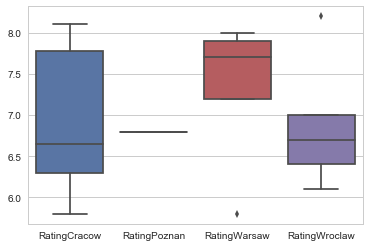

In [75]:
sns.set(style="whitegrid")
boxplot1= sns.boxplot(data=df_stats)

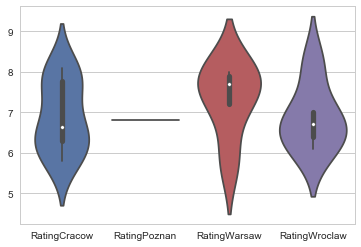

In [78]:
violinplot = sns.violinplot(data=df_stats)